## Vision

### Instructions
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit this notebook in the GitHub Classroom repo and any other results files under the result folder. 
 * Commits past the deadline will not be considered.
 * Extensions will be granted using the extension policy only, so please go through the policy carefully and reach out to the TAs beforehand.
 * **Download the data for section 2 and 3 from this [link](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/pranjali_pathre_research_iiit_ac_in/Elm4OCxD4VhBh6f9x2ufKsgBnWwkmWc-nXPjnS5jXWRTww?e=IzOlbb)**.

In [1]:
# List the imports here

import numpy as np

### SECTION 1: Epipolar lines and Epipoles

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix that encodes their relative geometry from these two images.

<img src="./data/1/img1.jpg" alt="image 1" width="400"/>
<img src="./data/1/img2.jpg" alt="image 2" width="400"/>

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions.

The point correspondences have been given in the folder `data/1`

In [155]:
def compute_fundamental(x1,x2):
    n = x1.shape[1]
    mat = []

    for i in range(n):
        x_1 = x1[0,i]
        x_2 = x2[0,i]
        y_1 = x1[1,i]
        y_2 = x2[1,i]
        mat.append(np.asarray([x_1*x_2, x_1*y_2, x_1, y_1*x_2, y_1*y_2, y_1, x_2, y_2, 1]))

    A = np.asarray(mat)

    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)
    U, S, Vt = np.linalg.svd(F)

    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),Vt))
    return F/F[2,2]

def normalize_points(x1, x2):
    n = x1.shape[1]
    mean_1 = np.mean(x1[:2], axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])

    T1 = np.array([[S1, 0, -S1 * mean_1[0]],[0, S1, -S1 * mean_1[1]],[0, 0, 1]])
    x1 = np.dot(T1, x1)

    mean_2 = np.mean(x2[:2], axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2, 0, -S2 * mean_2[0]],[0, S2, -S2 * mean_2[1]],[0, 0, 1]])
    x2 = np.dot(T2, x2)

    return x1, x2, T1, T2

def fundamental_matrix(x1, x2):
    x1, x2, T1, T2 = normalize_points(x1, x2)
    F = compute_fundamental(x1, x2)
    F = np.dot(T1.T, np.dot(F, T2))
    return F / F[2,2]

image1_points = np.asarray([[381, 402, 1],
 [452, 497, 1],
 [671, 538, 1],
 [501, 254, 1],
 [506, 381, 1],
 [474, 440, 1],
 [471, 537, 1],
 [498, 364, 1],
 [706, 319, 1],
 [635, 367, 1]])

image2_points = np.asarray([[390, 346, 1],
 [439, 412, 1],
 [651, 417, 1],
 [477, 194, 1],
 [482, 300, 1],
 [456, 359, 1],
 [454, 444, 1],
 [475, 287, 1],
 [686, 185, 1],
 [606, 253, 1]])

In [156]:
F = fundamental_matrix(image2_points.T, image1_points.T)
print(F)

[[ 5.37445646e-07  1.37045567e-05 -9.57120117e-03]
 [-1.26442845e-05 -5.69342841e-08  5.80683844e-03]
 [ 6.81833007e-03 -6.04021308e-03  1.00000000e+00]]


In [157]:
# To verify our fundamental matrix we can use the epipolar constraint for each point.
# If we get epipolar constraint close to zero, then we have a correct fundamental matrix.

for i in range(image1_points.shape[0]):
    x1 = image1_points[i]
    x2 = image2_points[i]

    epipolar_constraint = np.dot(x2, np.dot(F, x1))
    print(f"Epipolar Constraint for point {i}: {epipolar_constraint}")

Epipolar Constraint for point 0: -0.00028936704646143063
Epipolar Constraint for point 1: 0.0009776377845218676
Epipolar Constraint for point 2: -4.372161123100682e-05
Epipolar Constraint for point 3: -6.731469724829964e-05
Epipolar Constraint for point 4: -0.0006126868993310275
Epipolar Constraint for point 5: -0.00039079005814790513
Epipolar Constraint for point 6: -0.0009804456470772216
Epipolar Constraint for point 7: 0.0006386882475588607
Epipolar Constraint for point 8: -0.00017933094755884227
Epipolar Constraint for point 9: -5.5050426807756736e-05


## As we can see the epipolar constraint is close to 0 for each point, our fundamental matrix computation is correct.

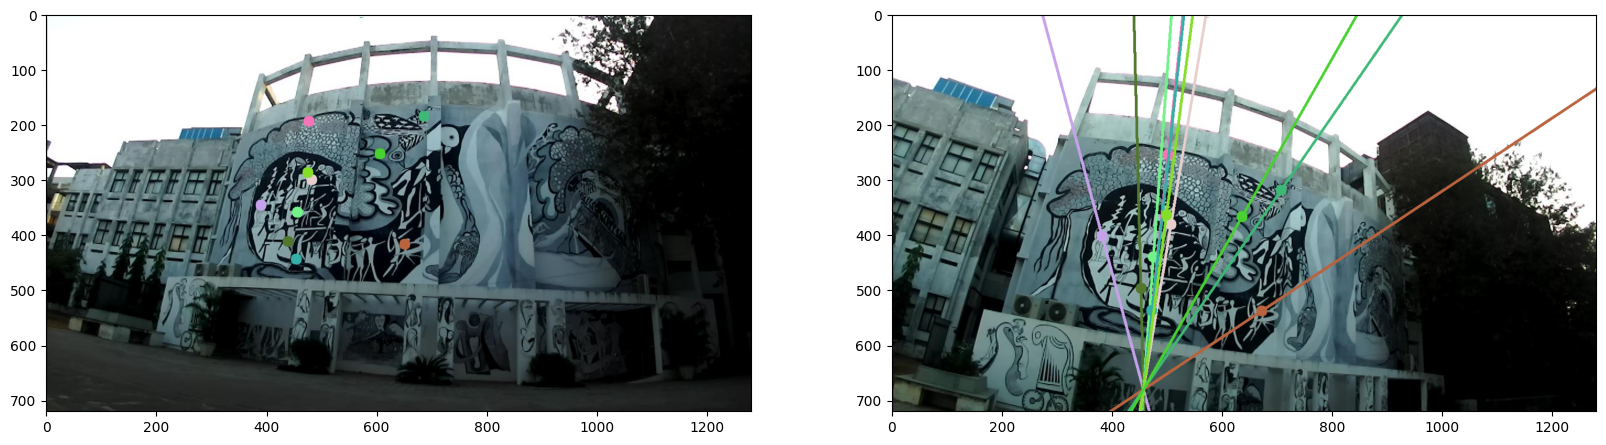

In [160]:
# !pip3 install opencv-python
import matplotlib.pyplot as plt
import cv2

def epipolar_lines(name_1, name_2, points1, points2, F):
    img1 = plt.imread(name_1)
    img2 = plt.imread(name_2)
    range_ = img1.shape[1]

    for i in range(points1.shape[0]):
        vec_points = np.array([points1[i][0], points1[i][1], 1])        
        line = np.dot(F, vec_points)
        a = line[0]
        b = line[1]
        c = line[2]

        x1, y1 = [0, int(-c / b) ] 
        x2, y2 = [range_, int(-(a* range_ + c) / b) ]

        color = [np.random.randint(2, 254), np.random.randint(2, 254), np.random.randint(2, 254)]

        img1 = cv2.line(img1, (x1, y1), (x2, y2), color, 4) 
        img1 = cv2.circle(img1, (int(points2[i][0]), int(points2[i][1])), 10, color, -1)
        img2 = cv2.circle(img2, (int(points1[i][0]), int(points1[i][1])), 10, color, -1)
        
    return img1, img2

%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (20, 20)) 
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines('data/1/img1.jpg','data/1/img2.jpg', image2_points, image1_points, F.T)
ax[0].imshow(img2)
ax[1].imshow(img1)

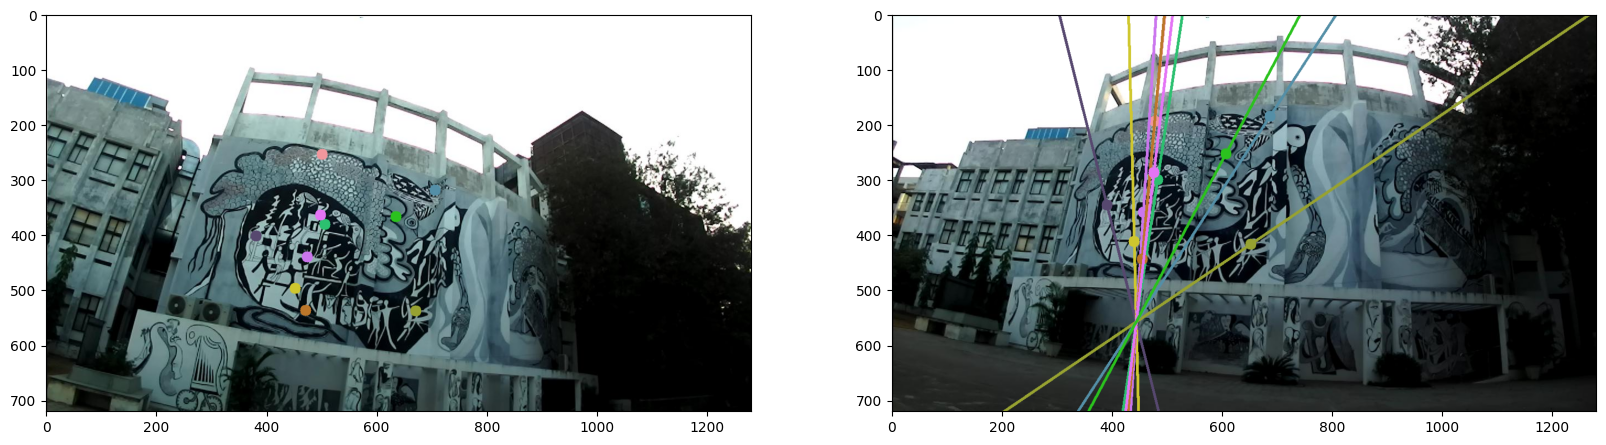

In [161]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (20, 20)) 
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines('data/1/img2.jpg','data/1/img1.jpg', image1_points, image2_points, F)
ax[0].imshow(img2)
ax[1].imshow(img1)

### SECTION 2: Visual Odometry

Visual odometry is the process of recovering the egomotion (the trajectory) of an agent using only the input from the camera or a system of cameras attached to the agent. This is a well-
studied problem in robotic vision and is a critical part of many applications such as mars rovers, and self-driving cars for localization. You will be implementing a basic monocular visual odometry algorithm in this part of the assignment.

To begin with, download all the required data from `data/2`. It contains a sequence of images from the KITTI dataset. The ground truth pose of each frame (in row-major order) and the camera parameters are provided as well.

#### Procedure
The following is an overview of the entire algorithm. 
1. Find the corresponding features between frames $I_{k}$ and $I_{k-1}$.
2. Using these features correspondances, estimate the essential matrix between the two images within a RANSAC sceme.
3. Decompose the essential matrix to obtain the relative rotation $R_k$ and transition $t_k$, and form the transformation $T_k$.
4. Scale the translation $t_k$ with the absolute or the relative scale. 
5. Concatenate the relative transformation by computing $C_k$ = $C_{k-1}$ $T_k$, where $C_{k-1}$ is the previous pose of the camera in the world frame. 
6. Repeat the above steps for the remaining pairs of frames.

The main task in computing visual odometry is to compute the relative transformation $T_k$ from each pair of images $I_k$ and $I_{k-1}$ and then to concatenate these transformations to recover the full trajectory of the camera. There are two broad approaches to compute the relative motion $T_k$: Appearance-based (or direct) method, which uses the intensity information of all the pixels in the input images and feature-based method which only uses salient and repeatable features extracted and tracked across the images. You will be implementing a feature-based method. 

For every new image $I_k$, the first step consists of detecting and matching 2D features with those from the previous frame. These 2D features are the locations in the image which we can reliably find in multiple images and possibly match them. To find these features use the inbuilt SIFT OpenCV implementation. 

Refer to [OpenCV documentation](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html) for the impementation details. 

As mentioned earlier, the main task is motion computation. Using these feature correspondences, implement the 8-point algorithm for fundamental matrix estimation. Implement it inside a RANSAC scheme to get rid of any outliers, as explained in class. Then, compute the essential matrix, and decompose it to the relative R and t using ```cv2.recoverPose```. Note that the function returns the R and t of the first camera with respect to the second, and not the other way around.

Now, you might recall that the absolute scale of the translation cannot be computed from just two images. The above function only returns the direction of t, as a unit vector. Use the ground truth translation to get the absolute scale, and multiply your unit translation with this scale. Then concatenate your transformations, and repeat for the next pair of frames to recover the full absolute trajector

Deliverables:
* A .txt file containing the estimated poses, provided in the same format as the ground truth.
* A plot of the estimated trajectory along with the ground truth trajectory. Also report the obtained trajectory error. Use [EVO](https://github.com/MichaelGrupp/evo) for this.
```
pip install evo --upgrade --no-binary evo
evo_traj kitti ground-truth.txt your-result.txt -va --plot --plot_mode xz
```
* Comment on the performance of your algorithm. When does it work well or it fails and why?

Referred to Udit Singh Parihar's implementation of 8-point algorithm inside a RANSAC scheme and the idea behind recovering poses correctly.

In [1]:
import glob
import random
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import sys

In [2]:
imgs = [cv2.imread(file) for file in sorted(glob.glob("./data/2/images/*.png"))]

In [3]:
K = np.array([[7.215377000000e+02,0.000000000000e+00,6.095593000000e+02],
              [0.000000000000e+00,7.215377000000e+02,1.728540000000e+02],
              [0.000000000000e+00,0.000000000000e+00,1.000000000000e+00]])

camera_height = 1.65

ground_truth = np.fromfile("./data/2/ground-truth.txt", dtype=float, count=-1, sep=" ")
ground_truth = np.reshape(ground_truth, (-1, 3,4)) # reshape to 3x4 matrices for each image as 3x3 for rotation and 3x1 for translation concat

In [10]:
import cv2
import numpy as np

def initialize_sift():
    """
    Initialize the SIFT detector.

    Returns:
    - cv2.SIFT: SIFT detector object.
    """
    return cv2.SIFT_create()

def detect_and_track_features(img1, img2, sift_detector):
    """
    Detect and track features between two images using SIFT and optical flow.

    Parameters:
    - img1 (np.ndarray): First image.
    - img2 (np.ndarray): Second image.
    - sift_detector (cv2.SIFT): SIFT detector.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: Arrays of detected and tracked feature points.
    """
    key_points = sift_detector.detect(img1)
    set1_pts = np.array([x.pt for x in key_points], dtype=np.float32)
    set_2_pts, status, _ = cv2.calcOpticalFlowPyrLK(img1, img2, set1_pts, None)
    status = status.reshape(status.shape[0])
    set1_pts = set1_pts[status == 1]
    set_2_pts = set_2_pts[status == 1]

    return set1_pts, set_2_pts

def normalize_points(points):
    """
    Normalize image coordinates.

    Parameters:
    - points (np.ndarray): Image coordinates.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: Normalized points and normalization matrix.
    """
    centroid = np.mean(points, axis=0)
    distances = np.linalg.norm(points - centroid, axis=1)
    avg_distance = np.mean(distances)
    scale_factor = np.sqrt(2) / avg_distance
    normalization_matrix = np.array([
        [scale_factor, 0, -scale_factor * centroid[0]],
        [0, scale_factor, -scale_factor * centroid[1]],
        [0, 0, 1]
    ])

    points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))
    normalized_homogeneous = normalization_matrix @ points_homogeneous.T
    normalized_points = normalized_homogeneous[:-1].T

    return normalized_points, normalization_matrix

def estimate_fundamental_matrix(pts1, pts2, success_probability=0.99, outlier_ratio=0.50, sample_size=8):
    """
    Estimate the fundamental matrix using the 8-point algorithm within RANSAC.

    Parameters:
    - pts1 (np.ndarray): Points in the first image.
    - pts2 (np.ndarray): Points in the second image.
    - success_probability (float): RANSAC success probability.
    - outlier_ratio (float): RANSAC outlier ratio.
    - sample_size (int): RANSAC sample size.

    Returns:
    - Tuple[np.ndarray, float]: Estimated fundamental matrix and RANSAC error.
    """
    best_fundamental_matrix = np.zeros((3, 3))
    homogeneous_component = np.ones((pts1.shape[0], 1))
    points1_homogeneous = np.hstack((pts1, homogeneous_component))
    points2_homogeneous = np.hstack((pts2, homogeneous_component))

    min_error = float('inf')  # Use infinity as the initial error
    matrix_coefficients = np.zeros((sample_size, 9))

    num_trials = int(np.log(1 - success_probability) / np.log(1 - (1 - outlier_ratio) ** sample_size))

    for trial in range(num_trials):
        for i in range(sample_size):
            idx = np.random.randint(0, pts1.shape[0] - 1)
            x1, y1 = points1_homogeneous[idx][0:2]
            x2, y2 = points2_homogeneous[idx][0:2]
            matrix_coefficients[i] = [x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1]

        _, _, vh = np.linalg.svd(matrix_coefficients, full_matrices=True)
        F_temp = vh[-1, :].reshape(3, 3)

        U, D, Vh = np.linalg.svd(F_temp, full_matrices=True)
        D[2] = 0  # Set the smallest singular value to 0
        F_temp = U @ np.diag(D) @ Vh

        val_minim = points2_homogeneous @ F_temp @ points1_homogeneous.T
        error = np.abs(np.diag(val_minim))
        error_mean = np.mean(error)

        if error_mean < min_error:
            min_error = error_mean
            best_fundamental_matrix = F_temp

    return best_fundamental_matrix, min_error

sift_detector = initialize_sift()

poses = []
current_pose = np.eye(4)
errors = []
R_store = []
t_store = []

for i in range(len(imgs)-1):
    set1_pts, set_2_pts = detect_and_track_features(imgs[i], imgs[i+1], sift_detector)
    set1_pts_norm, H_0 = normalize_points(set1_pts)
    set_2_pts_norm, H_1 = normalize_points(set_2_pts)

    F_unnorm, error = estimate_fundamental_matrix(set1_pts_norm, set_2_pts_norm, 0.95, 0.1, 8)

    F = H_1.T @ F_unnorm @ H_0
    E = K.T @ F @ K
    _, R, t, _ = cv2.recoverPose(E, set1_pts, set_2_pts, K)

    errors.append(error)
    R_store.append(R)
    t_store.append(t)

In [ ]:
tsRect = []

for i in range(1, len(imgs)):
    Ti_w = np.vstack((ground_truth[i], np.array([0, 0, 0, 1])))
    Tp_w = np.vstack((ground_truth[i-1], np.array([0, 0, 0, 1])))
    Tp_i = np.linalg.inv(Ti_w) @ Tp_w
    
    scale = np.linalg.norm(Tp_i[0:3, 3])
    tsRect.append(scale*t_store[i-1])
    print("Image pair {} and {} done".format(i-1,i))

In [ ]:
# Generate transfomation matrices by stacking R and t

Ts = []
Ts.append(np.eye(4))

for i in range(len(R_store)):
    Tp_i = np.vstack((np.hstack((R_store[i], tsRect[i])), np.array([0, 0, 0, 1])))
    Ti_p = np.linalg.inv(Tp_i)

    Ts.append(Ti_p)
    print("Image pair {} and {} done".format(i,i+1))

In [13]:
# Tp_w represents the pose of the camera with respect to the world
# Saving all poses with respect to the world for Evo evaluation

poses_file = open('./my_poses.txt', 'w')

initial_pose_w = Ts[0]
current_pose_w = initial_pose_w

# Write the initial pose
initial_pose_line = initial_pose_w.reshape(16, 1)
for i in range(12):
    num = str(initial_pose_line[i, 0])
    poses_file.write(num)
    if i != 11:
        poses_file.write(" ")
poses_file.write("\n")

# Iterate through the remaining poses
for i in range(1, len(imgs)):
    relative_pose_p = Ts[i]
    current_pose_w = np.dot(current_pose_w, relative_pose_p)
    
    # Write the ith pose    
    current_pose_line = current_pose_w.reshape(16)
    for j in range(12):
        num = str(current_pose_line[j])
        poses_file.write(num)
        if j != 11:
            poses_file.write(" ")
    poses_file.write("\n")
    current_pose_w

poses_file.close()

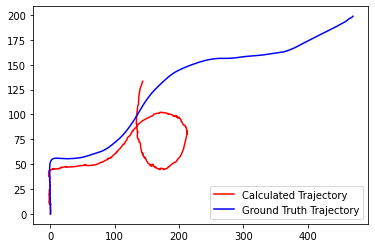

In [14]:
# Plotting trajectory obtained with respect to ground truth


X1 = []; Z1 = []
X2 = []; Z2 = []


T0_w = Ts[0]
Tp_w = T0_w

X1.append(T0_w[0, 3])
Z1.append(T0_w[2, 3])

X2.append(ground_truth[0, 0, 3])
Z2.append(ground_truth[0, 2, 3])

for i in range(1, len(imgs)):
    Ti_p = Ts[i]
    Ti_w = np.dot(Tp_w, Ti_p)
    
    X1.append(Ti_w[0, 3])
    Z1.append(Ti_w[2, 3])
    
    X2.append(ground_truth[i, 0, 3])
    Z2.append(ground_truth[i, 2, 3])
    
    Tp_w = Ti_w

plt.plot(X1, Z1, 'r-', label="Calculated Trajectory")
plt.plot(X2, Z2, 'b-', label="Ground Truth Trajectory")
plt.legend(loc='lower right')
plt.show()

In [ ]:
!pip3 install evo --upgrade --no-binary evo

In [9]:
!evo_traj kitti data/2/ground-truth.txt my_poses.txt --plot --plot_mode=xz

--------------------------------------------------------------------------------
name:	ground-truth
infos:	801 poses, 560.888m path length
--------------------------------------------------------------------------------
name:	my_poses
infos:	801 poses, 560.888m path length


With different parameters:

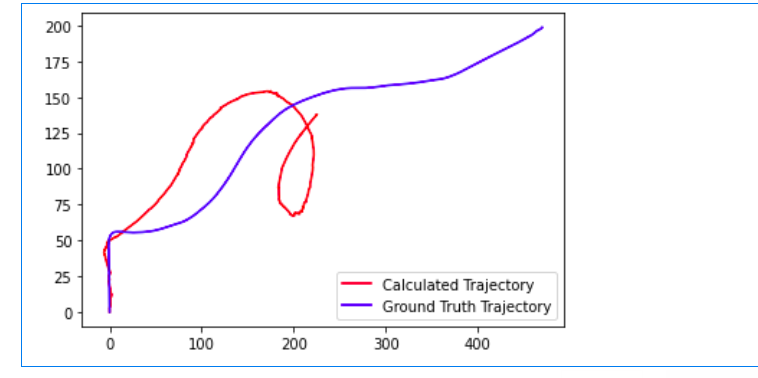

### SECTION 3: Stereo Dense Reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images. Refer `data/3` folder. It contains `img2` and `img3` folder for left and right stereo images respectively. `poses.txt` contains flatten 12 values of transformation matrix for each pose and `calib.txt` contains `K & Baseline`.

#### Procedure

1. Generate a disparity map for all given stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Note that the images provided are already rectified and undistorted.
2. Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them. Use `Open3D` for storing your point clouds.
3. Register (or transform) all the generated point clouds into your world frame by using the provided ground truth poses.
4. Visualize the registered point cloud data, in color.  Use Open3D for this.

    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

# THEORY:

### References used for Stereo Dense Reconstruction 

1. [John Lambert Github Pages on Stereo Vision](https://johnwlambert.github.io/stereo/)

2. [OpenCV SGBM docs](https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html)

3. [LearnOpenCV tutorial on Depth perception](https://learnopencv.com/depth-perception-using-stereo-camera-python-c/)

4. [Online implementations](https://github.com/UditSinghParihar/Mobile_Robotics_Assignments/blob/master/ass3/sol1.py)

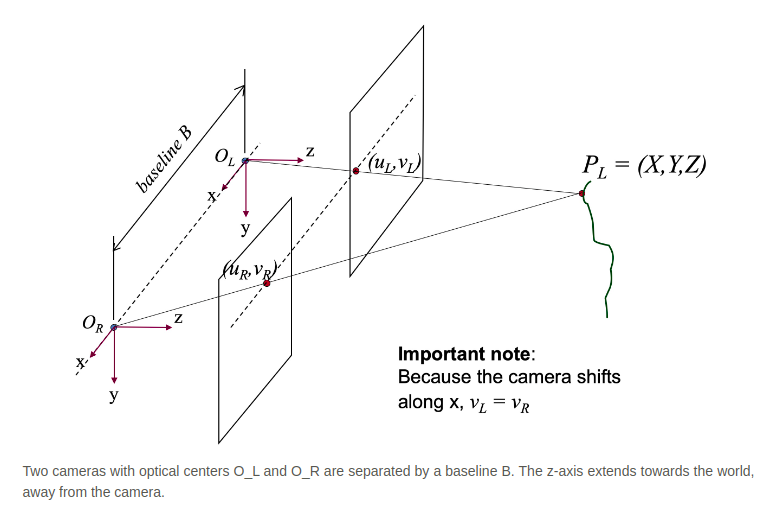

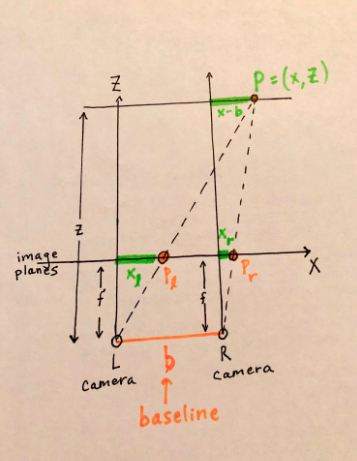

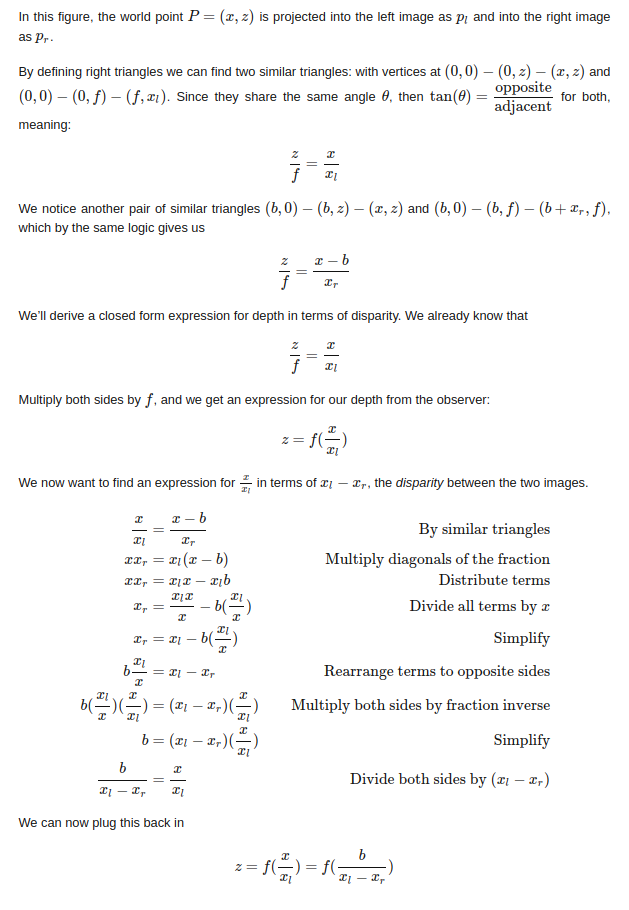

### SGBM Disparity Map computation:

Semi-Global Block Matching (SGBM):

SGBM is a stereo matching algorithm commonly used for disparity map computation.
It works by comparing corresponding blocks of pixels between the left and right images in a stereo pair.

#### Parameters:

SGBM takes several parameters to control its behavior. Common parameters include minDisparity, numDisparities, blockSize, P1, P2, disp12MaxDiff, uniquenessRatio, speckleWindowSize, and speckleRange.
These parameters influence how the algorithm matches pixels and how disparities are computed.
Matching Cost Computation:

SGBM computes a cost volume by measuring the dissimilarity between pixels in the left and right images.
The cost is typically computed using a pixel-wise matching strategy, considering intensity or feature differences.

#### Aggregation and Optimization:

SGBM then performs semi-global aggregation, considering not only local matching costs but also global information.
This step involves optimization techniques to refine the disparity values and reduce inconsistencies.

#### Disparity Map:
The final output is a disparity map, where each pixel corresponds to the estimated disparity (horizontal shift) between the left and right images.
Disparity values are inversely proportional to depth, meaning closer objects have higher disparity values.

## Using above we compute the disparity between two images of a point $(x,z)$

In [1]:
import numpy as np
import copy
import glob
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
B = 0.53790448812
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
              [0.000000e+00, 7.070912e+02, 1.831104e+02],
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])

imgs_L = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in sorted(glob.glob("./data/3/img2/*.png"))]
imgs_R = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in sorted(glob.glob("./data/3/img3/*.png"))]

focal_len = K[0, 0]
cx = K[0, 2]
cy = K[1, 2]

In [3]:
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

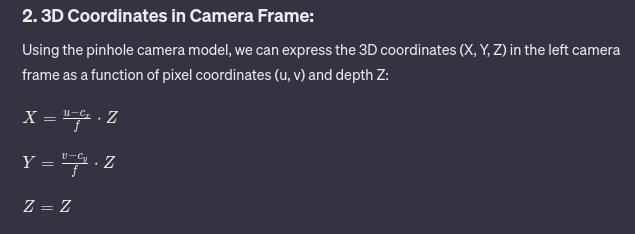
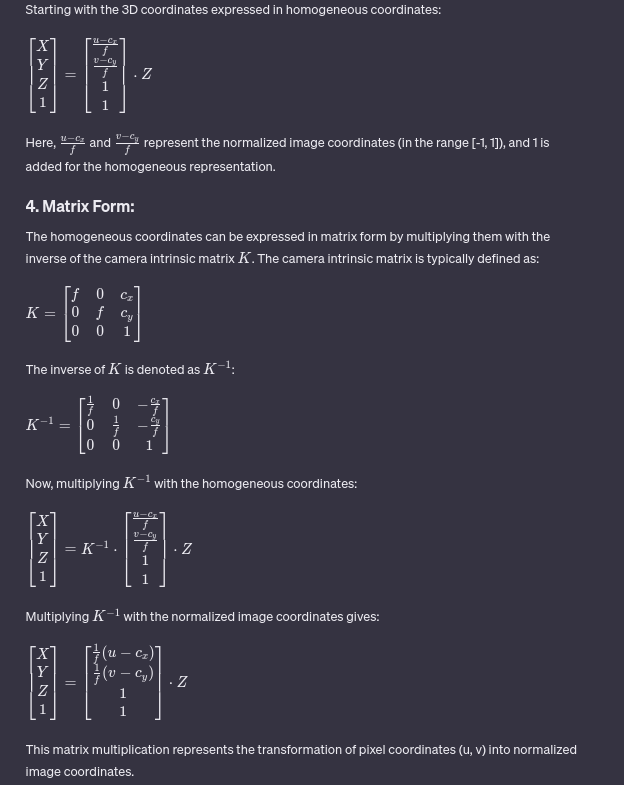

## The above matrix formulation helps us transform the pixel coordinated into normalized image coordinates (`calc_3d_coords()`)

In [4]:
hyper_params = {'window_size': 5,
        'min_disp': -1,
        'num_disp': 64,
        'blockSize': 5,
        'P1': 8*3*5**2,
        'P2': 16*3*5**2,
        'disp12MaxDiff': -1,
        'uniquenessRatio': 10,
        'speckleWindowSize': 5,
        'speckleRange': 5
}

def calc_disparity(left_img, right_img):
    stereo = cv2.StereoSGBM_create(
        minDisparity = hyper_params['min_disp'],
        numDisparities = hyper_params['num_disp'],
        blockSize = hyper_params['blockSize'],
        P1 = hyper_params['P1'],
        P2 = hyper_params['P2'],
        disp12MaxDiff = hyper_params['disp12MaxDiff'],
        uniquenessRatio = hyper_params['uniquenessRatio'],
        speckleWindowSize = hyper_params['speckleWindowSize'],
        speckleRange = hyper_params['speckleRange']
    )

    disparity_val = stereo.compute(left_img, right_img).astype(np.float32) / 16.0
    return disparity_val

def calc_3d_coords(disparity_val, B, K, left_img):
    disparity_flat = disparity_val.flatten()
    Z_L = np.divide(B*K[0, 0], disparity_flat)
    Z_L_T = np.reshape(Z_L, (1, Z_L.shape[0]))
    disparity_flat_s = np.reshape(disparity_flat, (1, disparity_flat.shape[0]))

    row, col = np.indices(left_img.shape[0:2])
    row_flat = row.flatten()
    col_flat = col.flatten()
    Img_indices = np.stack((row_flat.T, col_flat.T), axis=1)
    Img_indices_homo = np.append(Img_indices, np.ones((Img_indices.shape[0], 1)), axis=1)

    XYZ_L = np.multiply(disparity_flat_s, np.linalg.inv(K) @ Img_indices_homo.T)
    return XYZ_L

In [5]:
ground_truth = np.fromfile("./data/3/poses.txt", dtype=float, count=-1, sep=" ")
ground_truth = np.reshape(ground_truth, (-1, 3, 4))

In [6]:
def generate_custom_point_cloud(coords, colors, i):
    pointcloud = o3d.geometry.PointCloud()
    pointcloud.points = o3d.utility.Vector3dVector(coords.T) 
    pointcloud.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud("cloud_custom" + str(i) + ".ply", pointcloud)
    print("custom cloud " + str(i) + " saved")

def transform_to_world_frame(pointcloud, ground_truth, i):
    X_c = np.asarray(pointcloud.points)
    X_c_homo = np.append(X_c, np.ones((X_c.shape[0], 1)), axis=1)
    ground_truth_homo = np.append(ground_truth[i], np.array([[0, 0, 0, 1]]), axis=0)
    X_w = ground_truth_homo @ X_c_homo.T
    X_w_0 = np.delete(X_w.T, -1, 1)
    pointcloud.points = o3d.utility.Vector3dVector(X_w_0)

In [11]:
def main():
    # Q = np.float32([[1, 0, 0, 0],
    #                 [0, -1, 0, 0],
    #                 [0, 0, focal_len*0.03, 0],
    #                 [0, 0, 0, 1]])

    sample_size = 3

    for i in range(sample_size):
        disparity_val = calc_disparity(imgs_L[i], imgs_R[i])
        coords = calc_3d_coords(disparity_val, B, K, imgs_L[i])
        colors = imgs_L[i].reshape((imgs_L[i].shape[0]*imgs_L[i].shape[1], imgs_L[i].shape[2])) / 255.0
        generate_custom_point_cloud(coords, colors, i)

    my_pointcloud = [o3d.io.read_point_cloud(file) for file in sorted(glob.glob("./cloud_custom*.ply"))]

    def newTransformToWorlFrame(pointcloud, ground_truth, i):
        X_c = np.asarray(pointcloud.points)
        X_c_homo = np.append(X_c, np.ones((X_c.shape[0],1)), axis=1)
        ground_truth_copy = copy.deepcopy(ground_truth)
        ground_truth_homo = np.append(ground_truth_copy[i], np.array([[0,0,0,1]]), axis=0)
        X_w = ground_truth_homo @ X_c_homo.T # Transforming points in camera frame to world frame.
        X_w_0 = (np.delete(X_w.T, -1, 1))
        pointcloud.points = o3d.utility.Vector3dVector(X_w_0)
        pointcloud.colors = o3d.utility.Vector3dVector(np.asarray(pointcloud.colors))
        return pointcloud

    for j in range(sample_size):
        my_pointcloud[j] = newTransformToWorlFrame(my_pointcloud[j], ground_truth, j)

    o3d.visualization.draw_geometries([my_pointcloud[k] for k in range(sample_size)])

main()

/tmp/ipykernel_17723/4280520560.py:31: RuntimeWarning: divide by zero encountered in divide
  Z_L = np.divide(B*K[0, 0], disparity_flat)


custom cloud 0 saved
custom cloud 1 saved
custom cloud 2 saved


## Pointcloud generated for 3 sample points

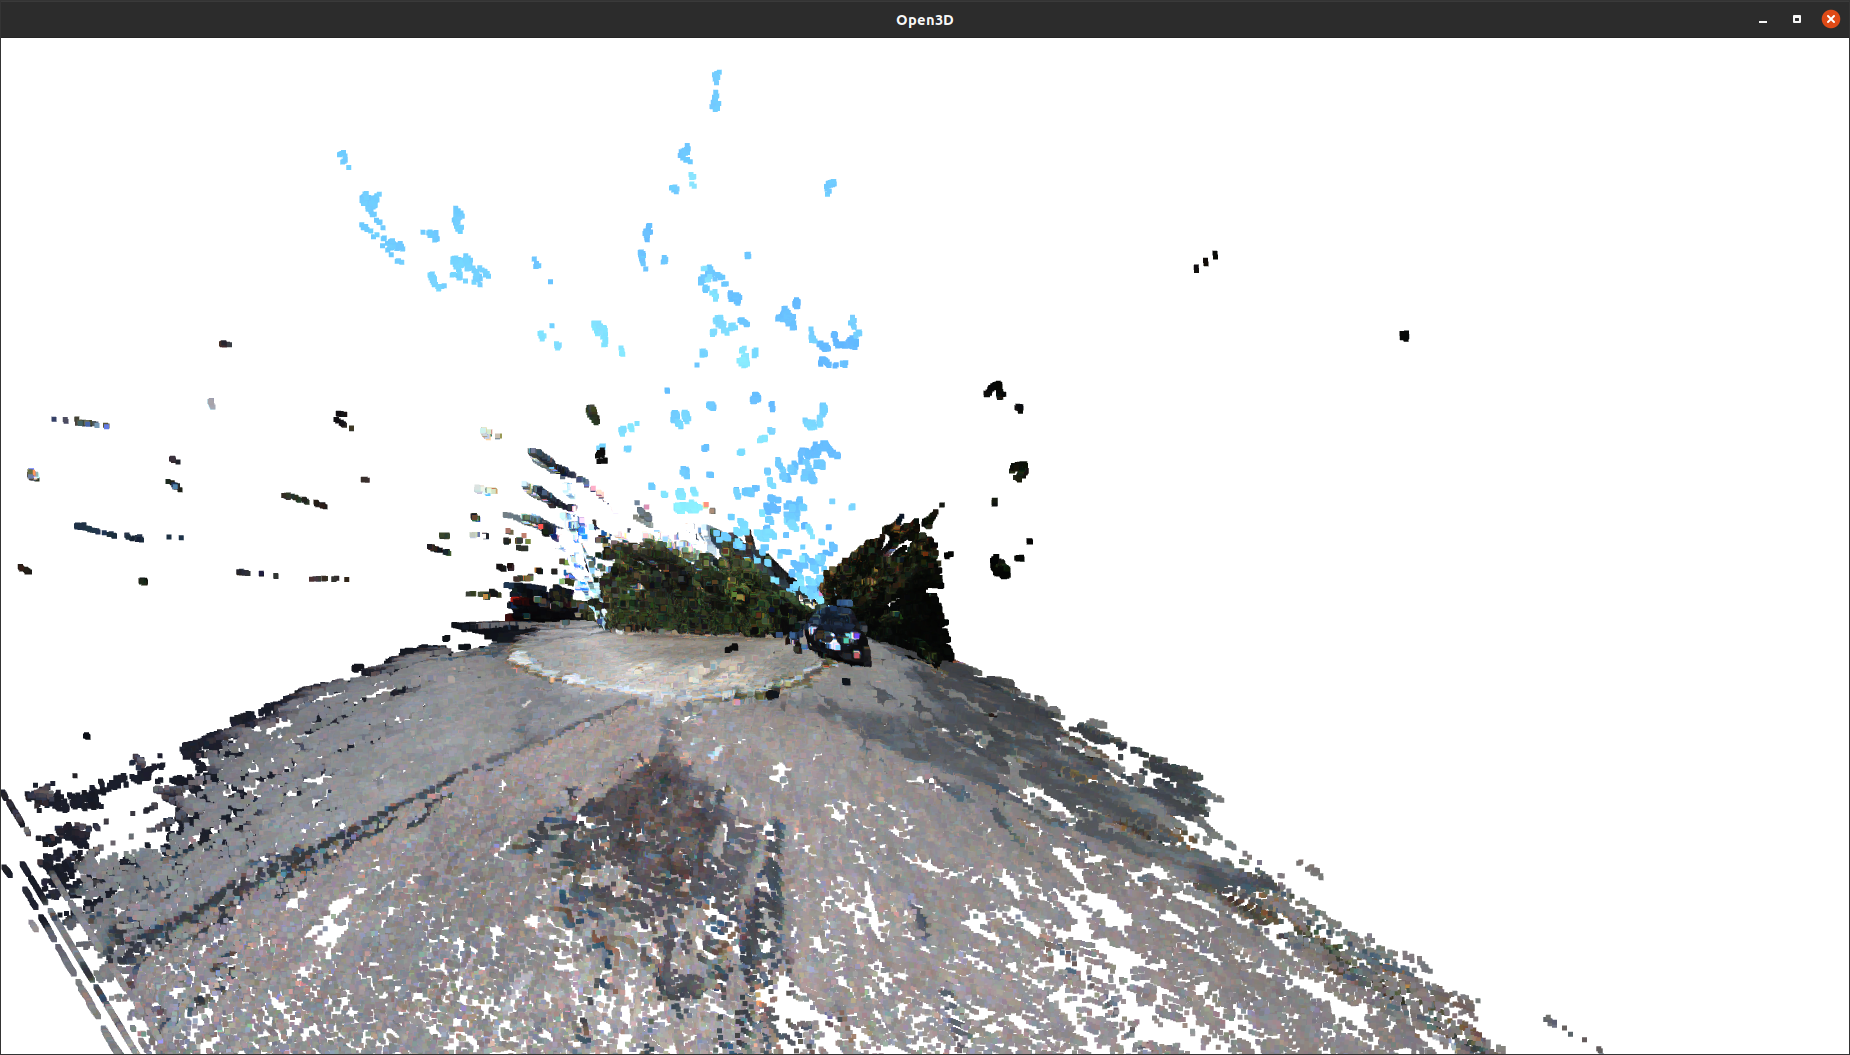
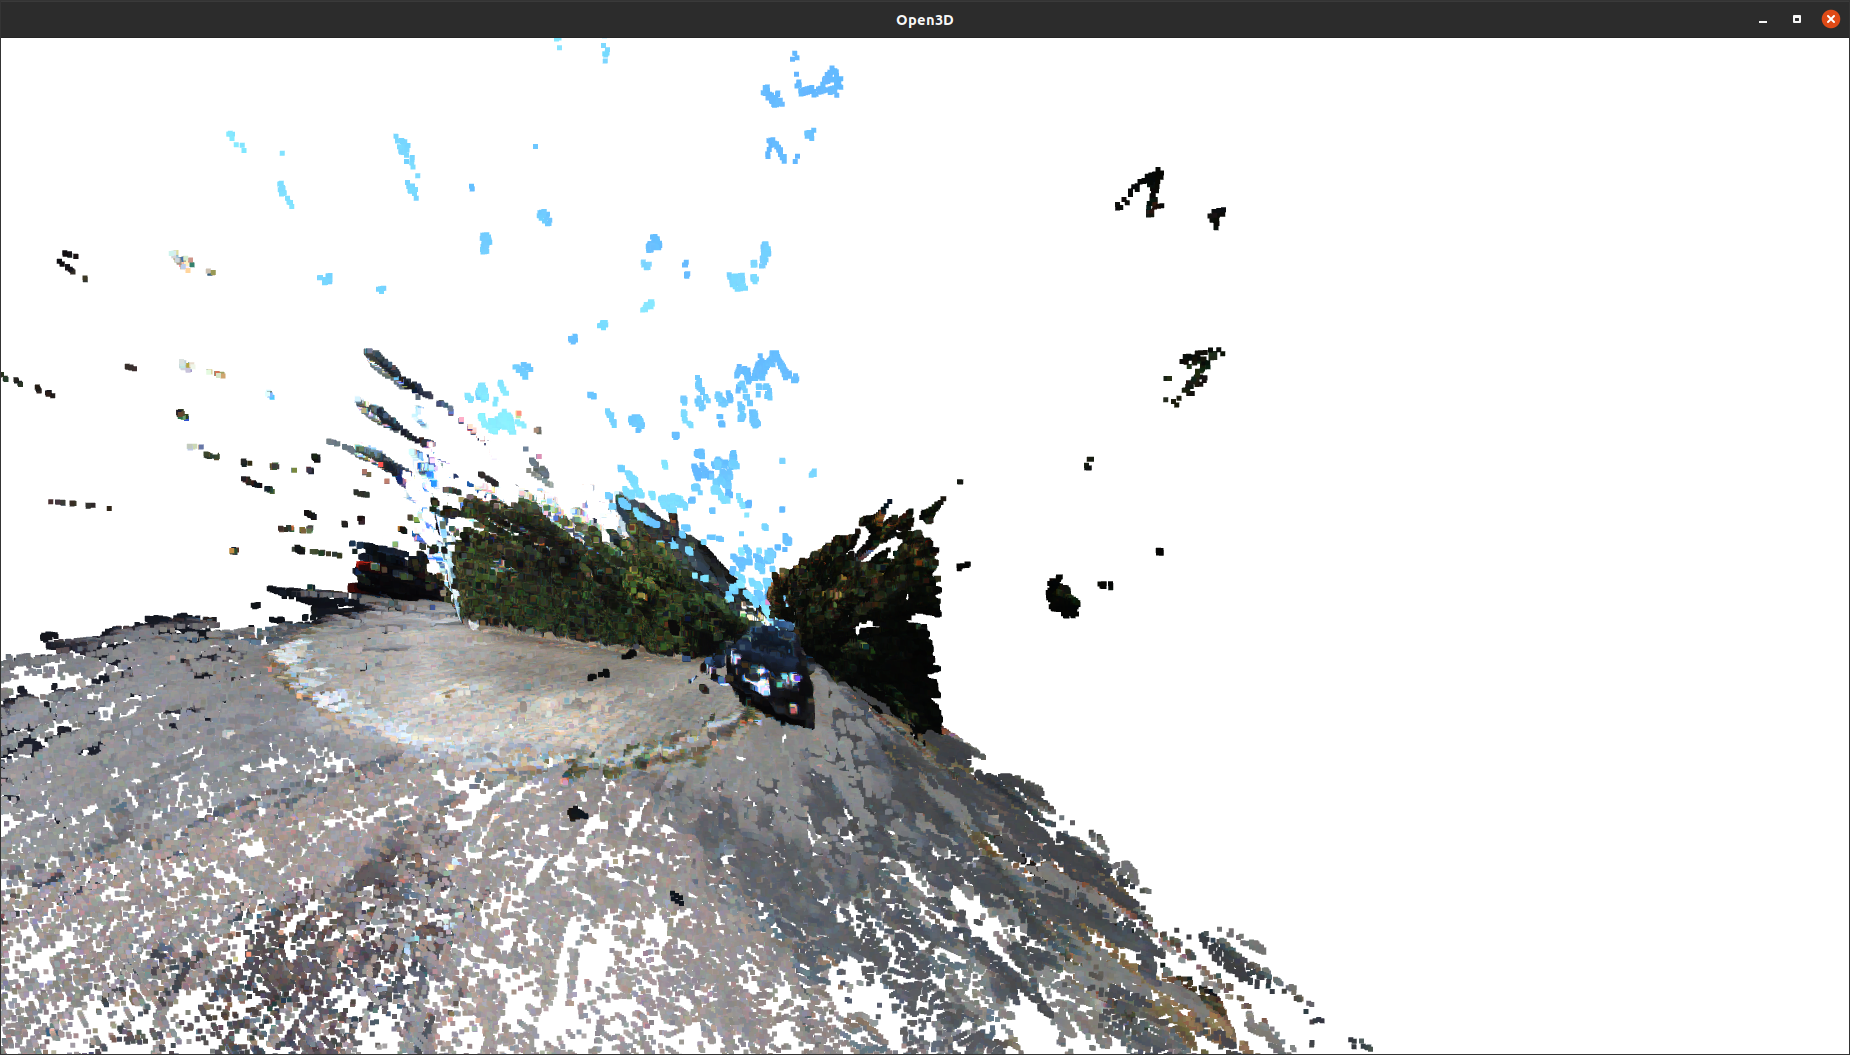

As we can see our reconstruction is being done correctly, there is some noise in comparison to OpenCV's reconstruction which can be reduced by tuning the parameters.